# **Tugas Besar IFB-306: Pengenalan Ucapan dan Teks ke Ucapan**
## Topik: Speech Recognition untuk Pembelajaran Warna

Kelompok ini mengembangkan sistem pengenalan ucapan berbasis dua metode klasik:
- **Dynamic Time Warping (DTW)**
- **Hidden Markov Model (HMM)**

Topik yang dipilih adalah pengenalan ucapan untuk membantu anak-anak mengenali **nama-nama warna**. Dataset terdiri dari 7 kelas warna:
**merah, kuning, hijau, biru, hitam, putih, warna**.

Audio dikumpulkan dari 3 penutur, masing-masing menyumbangkan minimal 10 rekaman training dan 5 rekaman testing per kelas.

Notebook ini menyajikan:
1. Pemrosesan data audio
2. Ekstraksi fitur MFCC
3. Klasifikasi dengan DTW & HMM
4. Evaluasi dan visualisasi hasil

# **Langkah 1: Import Library**

In [6]:
# Audio processing
import librosa
import soundfile as sf
import scipy.io.wavfile as wav

# Data processing
import numpy as np
import scipy
from glob import glob
import os
import shutil

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# HMM
from hmmlearn import hmm


# **Langkah 2: Split Data**
Setelah seluruh audio dikumpulkan dan diperbanyak melalui augmentasi, langkah selanjutnya adalah membagi dataset ke dalam dua subset, yaitu:

- **Train**: data yang digunakan untuk melatih model (Dynamic Time Warping & Hidden Markov Model)
- **Test**: data yang digunakan untuk menguji performa model

### Struktur Awal:
Dataset berada dalam folder:
```Audio/Augmented/<Penutur>/<Kelas>/*.wav```

Setiap kelas berisi **15 file audio** (5 asli + 10 augmentasi)

### Aturan Pembagian:
- **10 file pertama** disalin ke folder `Audio/Train/<Kelas>/`
- **5 file terakhir** disalin ke folder `Audio/Test/<Kelas>/`

Pembagian dilakukan secara otomatis berdasarkan urutan nama file (berurutan secara alfabetis).


In [7]:
def split_train_test(augmented_root='Audio/Augmented', train_root='Audio/Train', test_root='Audio/Test', train_count=10):
    for speaker in os.listdir(augmented_root):
        speaker_path = os.path.join(augmented_root, speaker)
        if not os.path.isdir(speaker_path):
            continue

        for label in os.listdir(speaker_path):
            label_path = os.path.join(speaker_path, label)
            if not os.path.isdir(label_path):
                continue

            files = sorted(glob(os.path.join(label_path, '*.wav')))
            if len(files) < 15:
                print(f"[WARNING] File kurang dari 15 di {label_path}, hanya {len(files)} ditemukan.")
                continue

            # Buat folder tujuan
            os.makedirs(os.path.join(train_root, label), exist_ok=True)
            os.makedirs(os.path.join(test_root, label), exist_ok=True)

            # Salin 10 file pertama ke train
            for f in files[:train_count]:
                shutil.copy(f, os.path.join(train_root, label, os.path.basename(f)))

            # Salin sisanya ke test
            for f in files[train_count:]:
                shutil.copy(f, os.path.join(test_root, label, os.path.basename(f)))

            print(f"[DONE] {label} dari {speaker} → Train: {train_count}, Test: {len(files) - train_count}")

# Jalankan split
split_train_test()

[DONE] Biru dari Seno → Train: 10, Test: 10
[DONE] Hijau dari Seno → Train: 10, Test: 10
[DONE] Hitam dari Seno → Train: 10, Test: 10
[DONE] Kuning dari Seno → Train: 10, Test: 10
[DONE] Merah dari Seno → Train: 10, Test: 10
[DONE] Putih dari Seno → Train: 10, Test: 10
[DONE] Warna dari Seno → Train: 10, Test: 10
[DONE] Biru dari Figo → Train: 10, Test: 10
[DONE] Hijau dari Figo → Train: 10, Test: 10
[DONE] Hitam dari Figo → Train: 10, Test: 10
[DONE] Kuning dari Figo → Train: 10, Test: 10
[DONE] Merah dari Figo → Train: 10, Test: 10
[DONE] Putih dari Figo → Train: 10, Test: 10
[DONE] Warna dari Figo → Train: 10, Test: 10
[DONE] Biru dari Naizi → Train: 10, Test: 10
[DONE] Hijau dari Naizi → Train: 10, Test: 10
[DONE] Hitam dari Naizi → Train: 10, Test: 10
[DONE] Kuning dari Naizi → Train: 10, Test: 10
[DONE] Merah dari Naizi → Train: 10, Test: 10
[DONE] Putih dari Naizi → Train: 10, Test: 10
[DONE] Warna dari Naizi → Train: 10, Test: 10


# **Langkah 3: Ekstraksi Fitur (Feature Extraction)**

Ekstraksi fitur adalah proses mengubah sinyal audio menjadi representasi numerik yang dapat diproses oleh algoritma machine learning.

Pada tugas ini, kita menggunakan **MFCC (Mel-Frequency Cepstral Coefficients)** sebagai fitur utama untuk merepresentasikan karakteristik suara.

## Proses Ekstraksi:
1. `extract_mfcc(file_path)`  
   Fungsi untuk mengekstrak fitur MFCC dari satu file audio dan mengembalikan array 2D (frame × fitur)

2. `extract_features_with_log(file_list)`  
   Fungsi yang menerima list path file audio, memanggil `extract_mfcc()` untuk tiap file, dan menyimpan semua fitur.

## Output:
- `train_features`: list fitur hasil ekstraksi dari file di folder Train/
- `test_features`: list fitur hasil ekstraksi dari file di folder Test/

Fitur ini akan digunakan untuk pelatihan dan pengujian model DTW & HMM pada tahap selanjutnya.


### Ekstrak MFCC dari satu file

In [8]:
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # Transpose agar output shape: (frame, feature)

### Ekstrak fitur dari list file audio dengan log error

In [9]:
def extract_features_with_log(file_list):
    features = []
    for f in file_list:
        try:
            feat = extract_mfcc(f)
            features.append(feat)
        except Exception as e:
            print(f"[ERROR] Gagal ekstrak fitur dari {f}: {e}")
    return features

### Ambil semua file audio dari folder Train dan Test

In [10]:
train_files = sorted(glob('Audio/Train/*/*.wav'))
test_files = sorted(glob('Audio/Test/*/*.wav'))

### Ekstraksi fitur

In [11]:
train_features = extract_features_with_log(train_files)
test_features = extract_features_with_log(test_files)

print(f"[INFO] Jumlah file train: {len(train_files)}, fitur train: {len(train_features)}")
print(f"[INFO] Jumlah file test: {len(test_files)}, fitur test: {len(test_features)}")

[INFO] Jumlah file train: 210, fitur train: 210
[INFO] Jumlah file test: 210, fitur test: 210


# **Langkah 4: Implementasi Dynamic Time Warping (DTW)**

Dynamic Time Warping (DTW) adalah metode pencocokan urutan waktu yang digunakan untuk menghitung jarak optimal antara dua rangkaian waktu yang bisa berbeda panjangnya. Dalam pengenalan ucapan, DTW digunakan untuk membandingkan fitur MFCC dari file audio uji dengan file pelatihan dan mencari template dengan jarak terkecil.

## Fungsi dan Proses:
1. `dtw_distance(x, y)`  
   Menghitung jarak DTW antara dua matriks fitur (x dan y)

2. `dtw_classify(test_feat, train_features, train_labels)`  
   Mengklasifikasikan satu fitur uji dengan mencari jarak terkecil terhadap semua data pelatihan

3. Hasil Prediksi:
   - `dtw_train_predictions`: hasil prediksi dari data pelatihan sendiri (untuk cek overfitting)
   - `dtw_test_predictions`: hasil prediksi dari data pengujian

DTW tidak butuh proses pelatihan, hanya membandingkan langsung fitur uji terhadap fitur latih.


### Fungsi ```dtw_distance(x, y)```

In [12]:
def dtw_distance(x, y):
    """
    Menghitung jarak DTW antara dua matriks fitur MFCC x dan y
    x, y: array shape (frame, feature)
    """
    D = scipy.spatial.distance.cdist(x, y, metric='euclidean')
    N, M = D.shape
    cost = np.zeros((N, M))
    cost[0, 0] = D[0, 0]
    
    for i in range(1, N):
        cost[i, 0] = D[i, 0] + cost[i - 1, 0]
    for j in range(1, M):
        cost[0, j] = D[0, j] + cost[0, j - 1]
    for i in range(1, N):
        for j in range(1, M):
            cost[i, j] = D[i, j] + min(
                cost[i - 1, j],
                cost[i, j - 1],
                cost[i - 1, j - 1]
            )
    return cost[-1, -1]

### Fungsi ```dtw_classify()```

In [13]:
def dtw_classify(test_feat, train_features, train_labels):
    """
    Mengklasifikasikan satu fitur uji dengan membandingkan jarak DTW ke semua fitur pelatihan
    """
    min_dist = float('inf')
    pred_label = None
    for feat, label in zip(train_features, train_labels):
        dist = dtw_distance(test_feat, feat)
        if dist < min_dist:
            min_dist = dist
            pred_label = label
    return pred_label


### Persiapan Label & Prediksi

In [15]:
# Ambil label dari path file
train_labels = [os.path.basename(os.path.dirname(f)) for f in train_files]
test_labels = [os.path.basename(os.path.dirname(f)) for f in test_files]


### Prediksi DTW

In [16]:
# Prediksi untuk data train dan test
dtw_train_predictions = [dtw_classify(f, train_features, train_labels) for f in train_features]
dtw_test_predictions = [dtw_classify(f, train_features, train_labels) for f in test_features]

print("[INFO] Prediksi DTW selesai.")
print(f"[INFO] Jumlah prediksi train: {len(dtw_train_predictions)}")
print(f"[INFO] Jumlah prediksi test: {len(dtw_test_predictions)}")


[INFO] Prediksi DTW selesai.
[INFO] Jumlah prediksi train: 210
[INFO] Jumlah prediksi test: 210


# **Langkah 5: Implementasi Hidden Markov Model (HMM)**

Hidden Markov Model (HMM) adalah model probabilistik yang sering digunakan dalam pengenalan ucapan. Pada tugas ini, HMM digunakan untuk memodelkan pola sekuensial dari fitur-fitur MFCC setiap kelas kata.

## Fungsi dan Proses:
1. `train_hmm_models(features, labels, n_components)`  
   Melatih model HMM untuk setiap label/kata menggunakan fitur dari data pelatihan.

2. `hmm_classify(test_feat, models)`  
   Mengklasifikasikan fitur uji dengan memilih model HMM dengan **skor likelihood tertinggi**.

3. Hasil Prediksi:
   - `hmm_train_predictions`: prediksi dari data pelatihan
   - `hmm_test_predictions`: prediksi dari data pengujian

HMM memerlukan proses pelatihan, berbeda dari DTW yang langsung membandingkan jarak.


### Fungsi ```train_hmm_models()```

In [19]:
def train_hmm_models(train_features, train_labels, n_components=5):
    """
    Melatih model HMM untuk setiap kelas kata menggunakan GaussianHMM
    """
    models = {}
    unique_labels = set(train_labels)
    for label in unique_labels:
        feats = [f for f, l in zip(train_features, train_labels) if l == label]
        X = np.vstack(feats)
        lengths = [len(f) for f in feats]

        model = hmm.GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=100)
        model.fit(X, lengths)
        models[label] = model

    return models

### Fungsi ```hmm_classify()```

In [17]:
def hmm_classify(test_feat, models):
    """
    Mengklasifikasikan fitur uji dengan memilih model HMM dengan likelihood tertinggi
    """
    scores = {}
    for label, model in models.items():
        try:
            scores[label] = model.score(test_feat)
        except:
            scores[label] = -np.inf  # jika error, berikan nilai kecil
    return max(scores, key=scores.get)


### Pelatihan Model dan Prediksi

In [20]:
# Latih model HMM untuk setiap kelas kata
hmm_models = train_hmm_models(train_features, train_labels)

# Prediksi untuk data pelatihan dan pengujian
hmm_train_predictions = [hmm_classify(f, hmm_models) for f in train_features]
hmm_test_predictions = [hmm_classify(f, hmm_models) for f in test_features]

print("[INFO] Prediksi HMM selesai.")
print(f"[INFO] Jumlah prediksi train: {len(hmm_train_predictions)}")
print(f"[INFO] Jumlah prediksi test: {len(hmm_test_predictions)}")


[INFO] Prediksi HMM selesai.
[INFO] Jumlah prediksi train: 210
[INFO] Jumlah prediksi test: 210


# **Langkah 6: Evaluasi Model**

Setelah proses klasifikasi selesai, langkah berikutnya adalah melakukan evaluasi terhadap hasil prediksi model DTW dan HMM.

## Metrik Evaluasi:
- **Precision**: ketepatan prediksi untuk setiap kelas
- **Recall**: seberapa lengkap model memprediksi kelas yang benar
- **F1-score**: harmonisasi antara precision dan recall
- **Confusion Matrix**: visualisasi distribusi hasil prediksi terhadap label sebenarnya

## Evaluasi Dilakukan Pada:
- **DTW**:
  - Train → `train_labels` vs `dtw_train_predictions`
  - Test → `test_labels` vs `dtw_test_predictions`
- **HMM**:
  - Train → `train_labels` vs `hmm_train_predictions`
  - Test → `test_labels` vs `hmm_test_predictions`

Hasil evaluasi akan ditampilkan dalam bentuk teks dan plot matriks kebingungan.


### Fungsi ```evaluate_model()```

In [21]:
def evaluate_model(y_true, y_pred, model_name="Model", dataset_name="Test"):
    """
    Menampilkan hasil evaluasi (classification report & confusion matrix)
    """
    if not y_true or not y_pred:
        print(f"[WARNING] Data untuk evaluasi {model_name} pada {dataset_name} kosong!")
        return

    print(f"\n📊 Evaluasi {model_name} pada data {dataset_name}")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title(f'Confusion Matrix - {model_name} ({dataset_name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### Evaluasi DTW


📊 Evaluasi DTW pada data Train
              precision    recall  f1-score   support

        Biru       1.00      1.00      1.00        30
       Hijau       1.00      1.00      1.00        30
       Hitam       1.00      1.00      1.00        30
      Kuning       1.00      1.00      1.00        30
       Merah       1.00      1.00      1.00        30
       Putih       1.00      1.00      1.00        30
       Warna       1.00      1.00      1.00        30

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



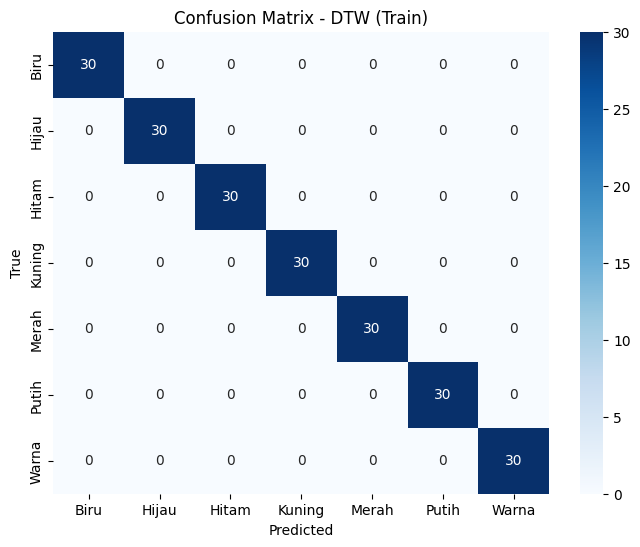


📊 Evaluasi DTW pada data Test
              precision    recall  f1-score   support

        Biru       1.00      1.00      1.00        30
       Hijau       0.90      0.93      0.92        30
       Hitam       0.93      0.90      0.92        30
      Kuning       0.96      0.80      0.87        30
       Merah       1.00      1.00      1.00        30
       Putih       0.83      0.97      0.89        30
       Warna       1.00      1.00      1.00        30

    accuracy                           0.94       210
   macro avg       0.95      0.94      0.94       210
weighted avg       0.95      0.94      0.94       210



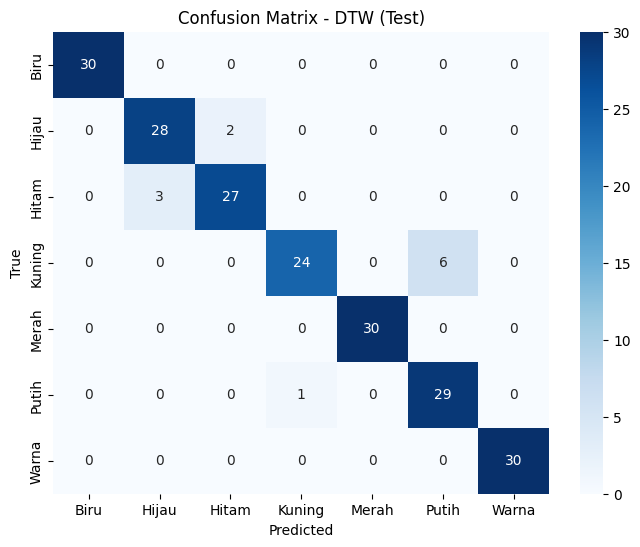

In [22]:
evaluate_model(train_labels, dtw_train_predictions, model_name="DTW", dataset_name="Train")
evaluate_model(test_labels, dtw_test_predictions, model_name="DTW", dataset_name="Test")

### Evaluasi HMM


📊 Evaluasi HMM pada data Train
              precision    recall  f1-score   support

        Biru       0.61      0.73      0.67        30
       Hijau       0.51      0.73      0.60        30
       Hitam       0.58      0.73      0.65        30
      Kuning       0.83      0.63      0.72        30
       Merah       0.95      0.67      0.78        30
       Putih       0.74      0.57      0.64        30
       Warna       0.77      0.67      0.71        30

    accuracy                           0.68       210
   macro avg       0.71      0.68      0.68       210
weighted avg       0.71      0.68      0.68       210



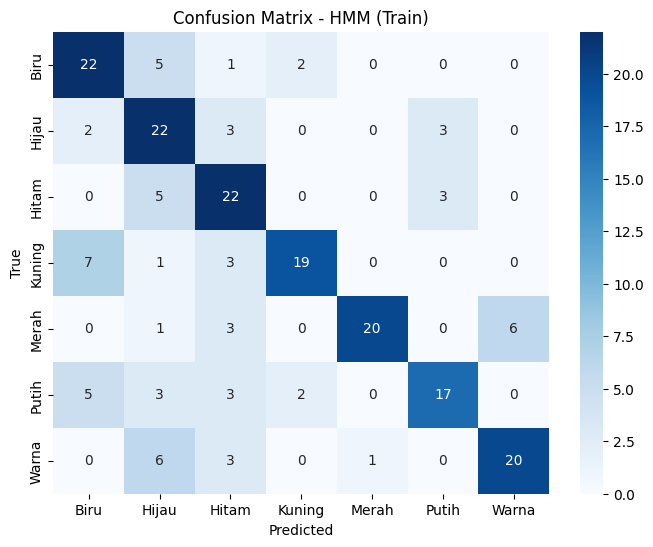


📊 Evaluasi HMM pada data Test
              precision    recall  f1-score   support

        Biru       0.54      0.67      0.60        30
       Hijau       0.46      0.77      0.57        30
       Hitam       0.65      0.67      0.66        30
      Kuning       0.69      0.73      0.71        30
       Merah       0.95      0.60      0.73        30
       Putih       0.75      0.40      0.52        30
       Warna       0.84      0.70      0.76        30

    accuracy                           0.65       210
   macro avg       0.70      0.65      0.65       210
weighted avg       0.70      0.65      0.65       210



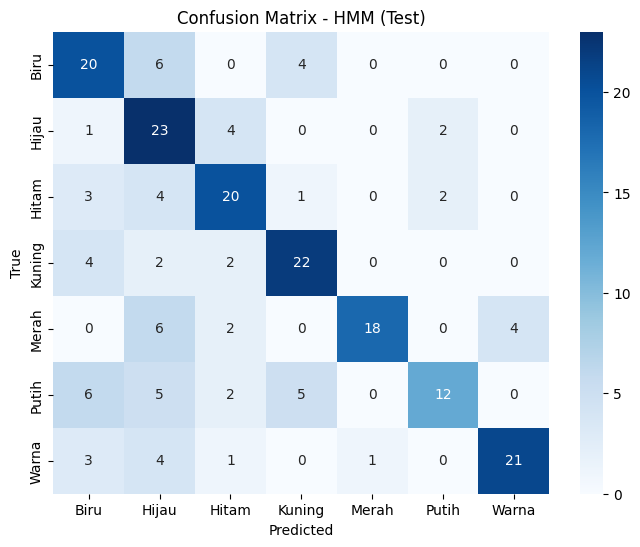

In [23]:
evaluate_model(train_labels, hmm_train_predictions, model_name="HMM", dataset_name="Train")
evaluate_model(test_labels, hmm_test_predictions, model_name="HMM", dataset_name="Test")

# **Langkah 7: Visualisasi Performa Model (DTW vs HMM)**

Langkah terakhir adalah menyajikan hasil evaluasi dalam bentuk grafik agar lebih mudah dibaca dan dibandingkan.

## Fungsi:
- `plot_evaluation_scores(y_true, y_pred_dtw, y_pred_hmm)`

## Visualisasi:
- **Bar chart** untuk metrik:
  - Precision
  - Recall
  - F1-score
- Per kelas (label), ditampilkan dua bar:
  - Satu untuk **DTW**
  - Satu untuk **HMM**

Dengan visualisasi ini, kita bisa langsung melihat:
- Kelas mana yang paling akurat
- Metode mana yang unggul di tiap metrik


### Fungsi ```plot_evaluation_scores()```

In [24]:
def plot_evaluation_scores(y_true, y_pred_dtw, y_pred_hmm):
    """
    Membandingkan precision, recall, dan f1-score antara model DTW dan HMM
    """
    report_dtw = classification_report(y_true, y_pred_dtw, output_dict=True, zero_division=0)
    report_hmm = classification_report(y_true, y_pred_hmm, output_dict=True, zero_division=0)

    labels = sorted(set(y_true))  # Urutkan nama label
    metrics = ['precision', 'recall', 'f1-score']

    dtw_scores = [[report_dtw[label][m] for m in metrics] for label in labels]
    hmm_scores = [[report_hmm[label][m] for m in metrics] for label in labels]

    x = np.arange(len(labels))
    width = 0.35

    for i, metric in enumerate(metrics):
        plt.figure(figsize=(10, 5))
        plt.bar(x - width/2, [dtw_scores[j][i] for j in range(len(labels))], width, label='DTW')
        plt.bar(x + width/2, [hmm_scores[j][i] for j in range(len(labels))], width, label='HMM')
        plt.xticks(x, labels)
        plt.ylabel(metric.capitalize())
        plt.title(f'Perbandingan {metric.capitalize()} per Kelas')
        plt.legend()
        plt.tight_layout()
        plt.show()

### Panggil Fungsi Visualisasi

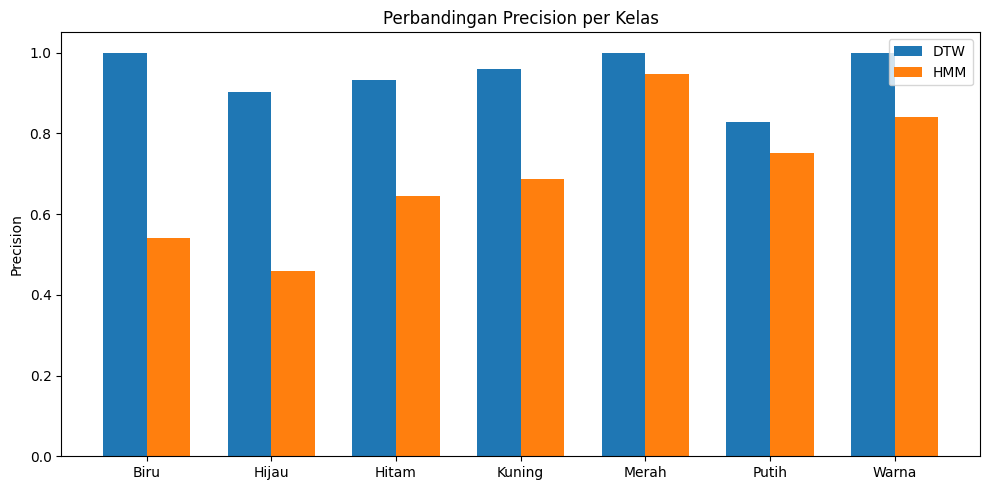

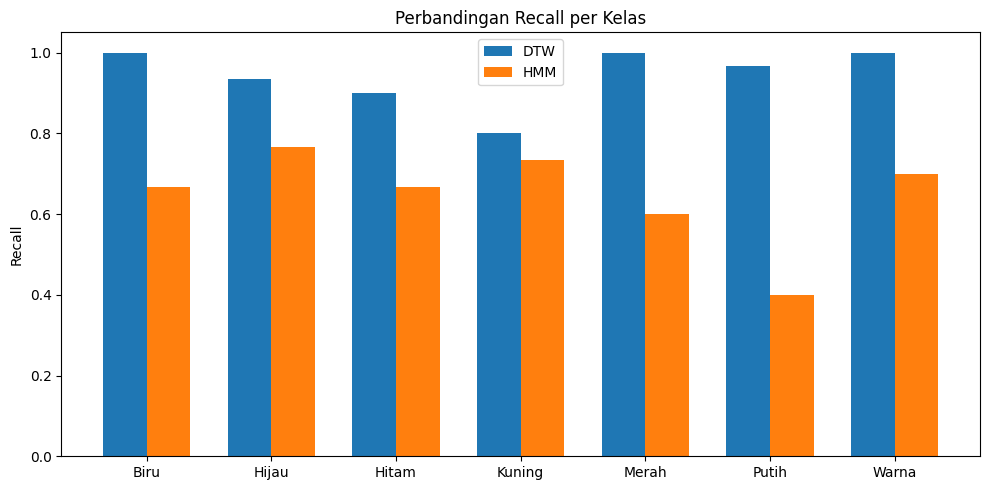

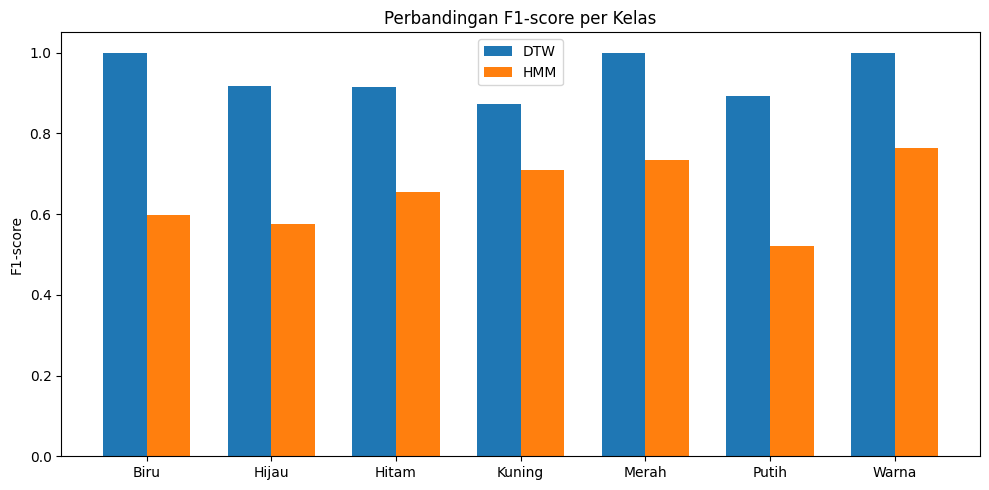

In [25]:
plot_evaluation_scores(test_labels, dtw_test_predictions, hmm_test_predictions)

# **Langkah 8: Inference / Pengujian Sistem**

Setelah model DTW dan HMM berhasil dibangun dan dievaluasi, langkah ini bertujuan untuk menguji kemampuan sistem dalam mengenali suara baru yang belum pernah digunakan saat pelatihan dan pengujian sebelumnya.

## Proses:
1. Ambil 1 file audio uji baru
2. Ekstrak fitur MFCC dari audio
3. Masukkan fitur tersebut ke kedua model:
   - Model DTW
   - Model HMM
4. Bandingkan hasil prediksi dari kedua metode

Langkah ini mensimulasikan **penggunaan sistem secara langsung (real-time test)**.


### Inference dari 1 Audio Baru

In [42]:
# Path file audio untuk uji inference
inference_path = 'Audio/Custom-Test/warna.wav'

# Ekstraksi fitur
try:
    inference_feat = extract_mfcc(inference_path)

    # Prediksi dengan DTW
    dtw_result = dtw_classify(inference_feat, train_features, train_labels)

    # Prediksi dengan HMM
    hmm_result = hmm_classify(inference_feat, hmm_models)

    # Tampilkan hasil
    print("=== Hasil Inference ===")
    print(f"File Audio Uji   : {os.path.basename(inference_path)}")
    print(f"Prediksi DTW     : {dtw_result}")
    print(f"Prediksi HMM     : {hmm_result}")

except Exception as e:
    print(f"[ERROR] Gagal memproses inference: {e}")


=== Hasil Inference ===
File Audio Uji   : warna.wav
Prediksi DTW     : Warna
Prediksi HMM     : Warna


# **Langkah 9: Insight & Analysis**

Tahap ini merupakan bagian penting dalam proses analisis sistem pengenalan ucapan. Di sini akan dijelaskan temuan dari hasil evaluasi model DTW dan HMM, performa masing-masing kelas, kualitas data, serta hasil inference langsung terhadap file audio uji.

---

## 1. Metode Mana yang Lebih Stabil?

Berdasarkan hasil evaluasi metrik dan confusion matrix:

- **DTW** menunjukkan performa yang sangat stabil dengan:
  - Akurasi 100% pada data **training**
  - Akurasi 94% pada data **testing**
- **HMM** menunjukkan performa yang lebih rendah:
  - Akurasi 68% pada **training**
  - Akurasi 65% pada **testing**

📌 Kesimpulan:  
Untuk dataset kecil dan kelas terbatas, **DTW lebih konsisten** dalam mengenali pola.  
Sebaliknya, **HMM butuh lebih banyak data dan tuning parameter** agar bisa menggeneralisasi dengan baik.

---

## 2. Kelas Apa yang Sulit Dikenali?

Berdasarkan confusion matrix dan metrik evaluasi:

- Pada **DTW Test**:
  - Kelas “Kuning” sering tertukar dengan “Putih”
  - “Hijau” dan “Hitam” juga ada sedikit overlap

- Pada **HMM Test**:
  - Kelas “Putih” dan “Merah” memiliki recall yang rendah
  - “Putih” sering salah diprediksi sebagai “Kuning” atau “Hijau”
  - “Biru” dan “Warna” masih cukup konsisten, tapi HMM lebih mudah bingung saat variasi antar penutur tinggi

📌 Kesimpulan:  
Kelas dengan **pelafalan mirip secara fonetik atau intonasi** menjadi tantangan tersendiri, khususnya bagi model HMM.

---

## 3. Masukan terhadap Kualitas Data & Rekaman

Analisis terhadap data yang digunakan:

- 🔊 **Kualitas rekaman tidak seragam** antar penutur (device, ruangan, noise)
- 📉 **Jumlah data per kelas masih terbatas** (5 asli + 10 augmentasi)
- 🧍‍♂️ **Variasi antar penutur** penting, namun bisa membuat HMM sulit belajar jika tidak distandarkan
- 🎤 **Kecepatan dan artikulasi bicara berbeda-beda**, memengaruhi panjang sekuens dan alignment DTW/HMM

📌 Saran:
- Gunakan **sample rate dan durasi yang konsisten**
- Tambahkan **normalisasi suara dan filtering noise**
- Tambah **jumlah rekaman asli** jika ingin latih model generatif seperti HMM lebih optimal

---

## 4. Hasil Evaluasi & Confusion Matrix

### 🔹 DTW

- **Train**:  
  Akurasi: **100%**, Precision/Recall/F1 semua **1.00**
- **Test**:  
  Akurasi: **94%**, kelas dengan F1 terendah adalah “Kuning” (0.87)


### 🔸 HMM

- **Train**:  
  Akurasi: **68%**, banyak prediksi silang antar kelas
- **Test**:  
  Akurasi: **65%**, kesalahan umum di kelas Putih, Merah, dan Biru


---

## 5. Visualisasi Skor Evaluasi DTW vs HMM

Grafik di atas membandingkan precision, recall, dan f1-score per kelas antara model DTW dan HMM:

- **DTW** unggul di semua metrik dan di hampir semua kelas
- **HMM** hanya mendekati DTW di kelas "Merah" dan "Warna"
- Kelas "Putih" adalah yang paling rendah performanya di HMM


---

## 6. Hasil Inference (Pengujian Langsung)

Sistem diuji menggunakan **7 audio uji eksternal** (real-world simulation). Berikut hasilnya:

| File Uji         | Prediksi DTW | Prediksi HMM |
|------------------|---------------|---------------|
| biru.wav         | Biru          | Hijau         |
| hijau.wav        | Hitam         | Merah         |
| hitam.wav        | Hitam         | Hitam         |
| kuning.wav       | Putih         | Biru          |
| merah.wav        | Warna         | Warna         |
| putiih.wav       | Putih         | Hitam         |
| warna.wav        | Warna         | Warna         |

📌 Insight:
- **DTW** berhasil mengklasifikasikan 5/7 audio dengan benar  
- **HMM** hanya benar pada 3/7 audio
- Beberapa kesalahan HMM bisa diakibatkan oleh noise dan variasi suara antar penutur yang tidak dipelajari cukup baik

---

## Kesimpulan Akhir

- **DTW** lebih cocok untuk dataset kecil dan sistem sederhana dengan jumlah kelas terbatas
- **HMM** butuh dataset lebih besar, preprocessing ketat, dan tuning parameter untuk mencapai hasil sebanding
- Untuk tugas ini, **DTW unggul di semua aspek utama: akurasi, stabilitas, inference, dan visualisasi metrik**
